<a href="https://colab.research.google.com/github/Rogerio-mack/work/blob/main/IMT_FOSP_IT_JOAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lifelines --quiet

In [3]:
!pip install scikit-survival --quiet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from lifelines import CoxPHFitter
from lifelines import WeibullFitter
from lifelines import WeibullAFTFitter

from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored


# Dados

In [5]:
import pandas as pd
df = pd.read_csv('https://github.com/Rogerio-mack/work/raw/refs/heads/main/colo.csv')
display(df.head())
df.shape

,ESCOLARI,IDADE,SEXO,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,TOPO_C184,TOPO_C185,TOPO_C186,TOPO_C187,TOPO_C188,TOPO_C189,TOPO_C199,TOPO_C209,event,time
0,9,79,1,9,1,7.0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,29.0
1,9,68,2,9,1,2.0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,50.0
2,9,58,2,9,1,2.0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,47.0
3,9,52,2,9,1,2.0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,15.0
4,9,62,2,2,1,3.0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9.0


(37499, 36)

# Análise Exploratória



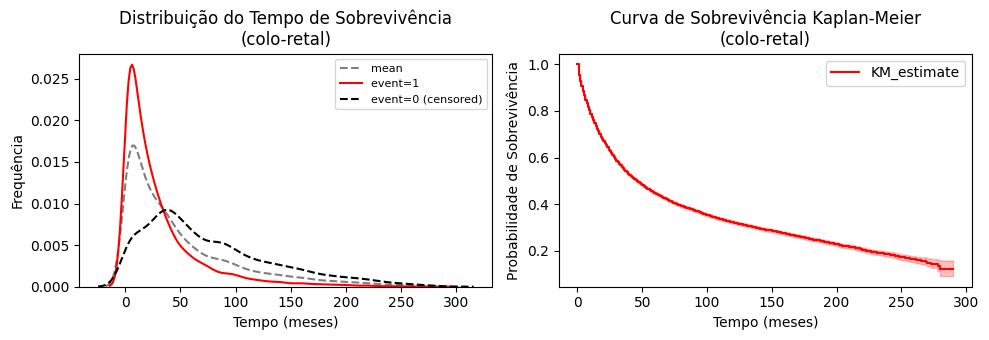

In [6]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(df['time'], df['event'])

fig, ax = plt.subplots(1,2,figsize=(10, 3.5))

sns.kdeplot(df['time'], label='mean',ax=ax[0], color='k', linestyle='--', alpha=0.5)
sns.kdeplot(df[ df['event'] == 1 ]['time'],label='event=1 ',ax=ax[0], color='r')
sns.kdeplot(df[ df['event'] == 0 ]['time'],label='event=0 (censored)',ax=ax[0], color='k', linestyle='--')
ax[0].legend(fontsize=8)
ax[0].set_title('Distribuição do Tempo de Sobrevivência\n(colo-retal)')
ax[0].set_xlabel('Tempo (meses)')
ax[0].set_ylabel('Frequência')

# Curva de sobrevivência de Kaplan-Meier
kmf.plot_survival_function(ax=ax[1],color='r')
ax[1].set_title('Curva de Sobrevivência Kaplan-Meier\n(colo-retal)')
ax[1].set_xlabel('Tempo (meses)')
ax[1].set_ylabel('Probabilidade de Sobrevivência')

plt.tight_layout()
plt.show()

In [7]:
df['event'].replace({1:'event',0:'censored'}).value_counts('event')

,proportion
event,
event,0.588762
censored,0.411238


In [8]:
df['SEXO'].replace({1:'masculino',2:'feminino'}).value_counts('SEXO')

,proportion
SEXO,
masculino,0.5178
feminino,0.4822


In [9]:
less_25 = len(df[df['IDADE'] < 25])
between_25_60 = len(df[(df['IDADE'] >= 25) & (df['IDADE'] <= 60)])
greater_60 = len(df[df['IDADE'] > 60])

print(f"Idade < 25: {np.round(less_25/len(df),3)}")
print(f"Idade entre 25-60: {np.round(between_25_60/len(df),3)}")
print(f"Idade > 60: {np.round(greater_60/len(df),3)}")

Idade < 25: 0.003
Idade entre 25-60: 0.426
Idade > 60: 0.571


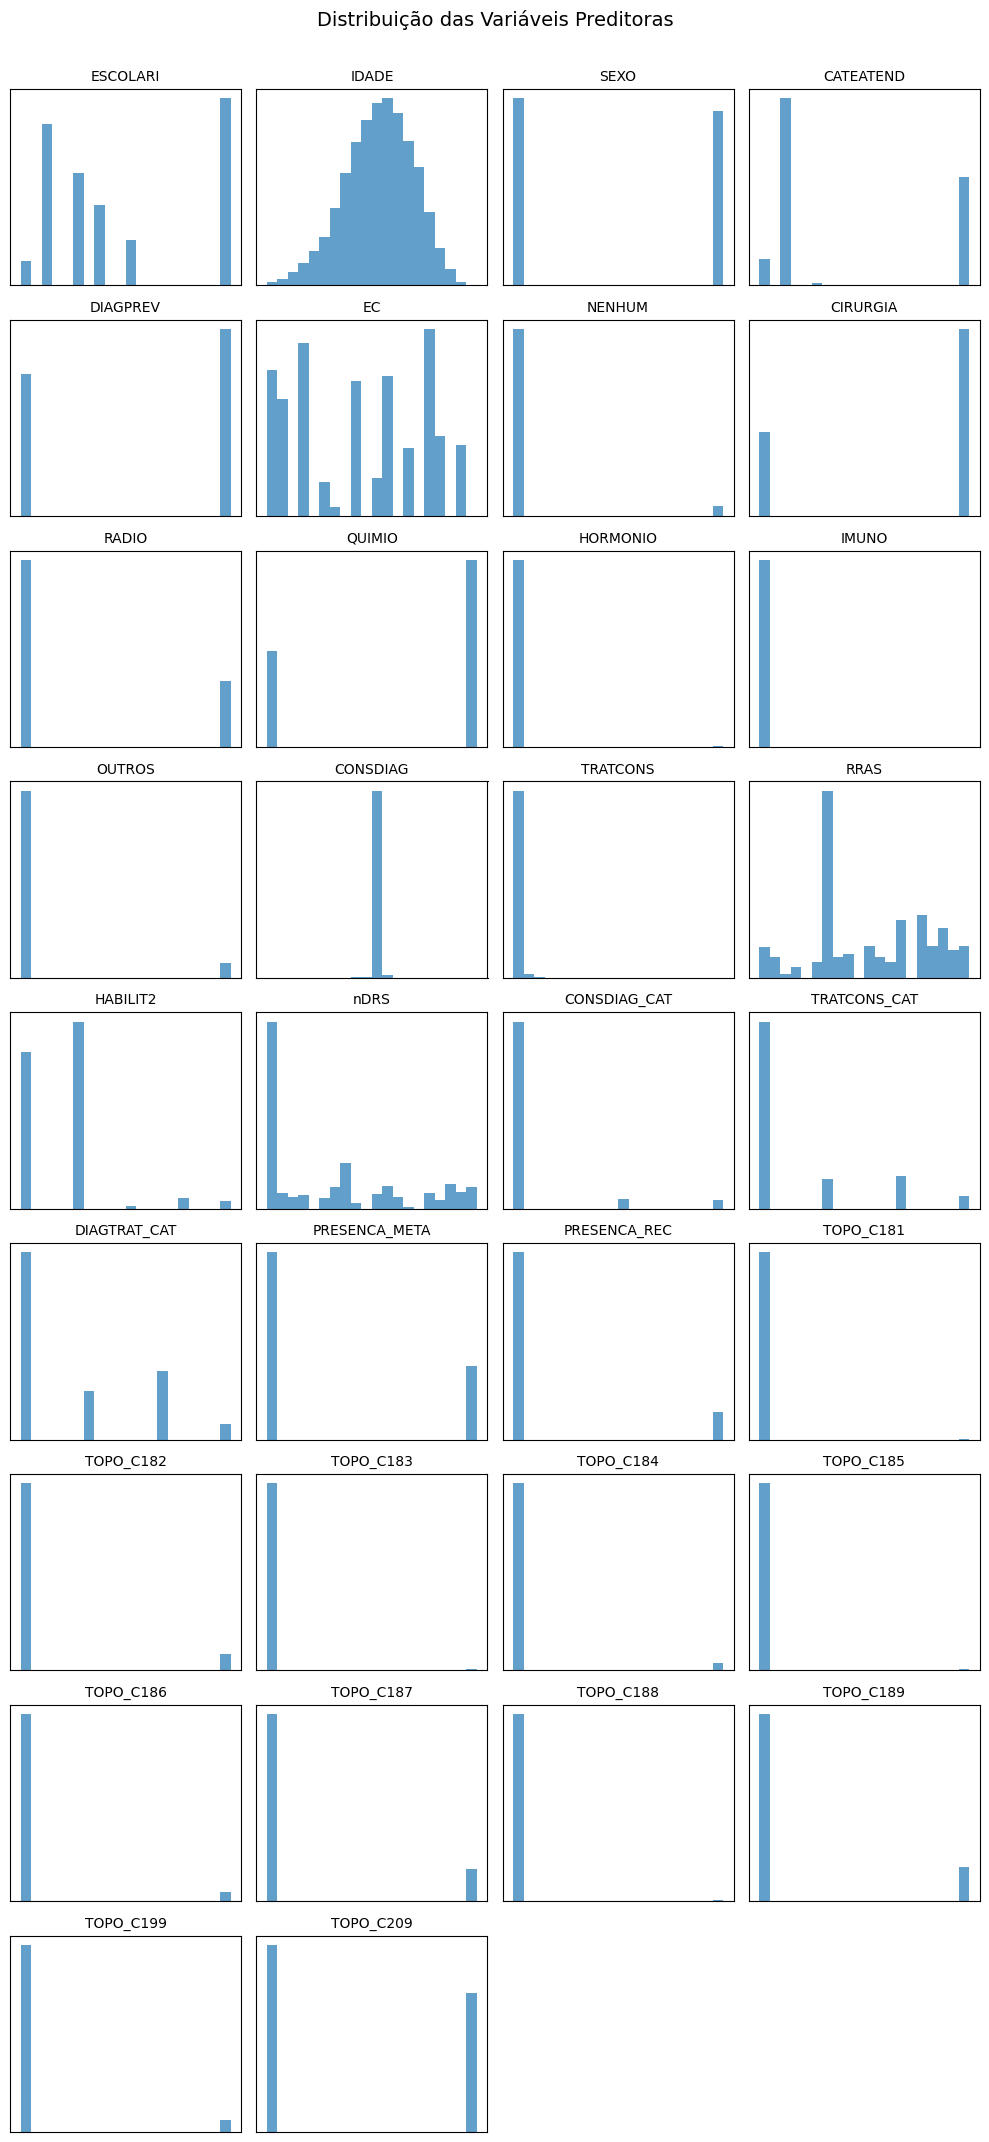

In [10]:
import matplotlib.pyplot as plt

num_vars = len(df.columns)
num_cols = 4
num_rows = (num_vars + num_cols - 1) // num_cols

plt.figure(figsize=(10, 2.5*num_rows))

for i, col in enumerate(df.drop(columns=['event','time']).columns):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(df[col], bins=20, alpha=0.7)
    plt.title(f'{col}', fontsize=10)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.suptitle('Distribuição das Variáveis Preditoras', fontsize=14)

plt.show()

# Modelos de Cox

## Seleção de diferentes conjuntos preditores

In [11]:
df.columns

Index(['ESCOLARI', 'IDADE', 'SEXO', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'RRAS', 'HABILIT2', 'nDRS', 'CONSDIAG_CAT',
       'TRATCONS_CAT', 'DIAGTRAT_CAT', 'PRESENCA_META', 'PRESENCA_REC',
       'TOPO_C181', 'TOPO_C182', 'TOPO_C183', 'TOPO_C184', 'TOPO_C185',
       'TOPO_C186', 'TOPO_C187', 'TOPO_C188', 'TOPO_C189', 'TOPO_C199',
       'TOPO_C209', 'event', 'time'],
      dtype='object')

In [12]:
preditores_1 = ['ESCOLARI', 'IDADE', 'SEXO']
preditores_2 = ['CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'IMUNO']
preditores_3 = [x for x in df.columns if 'TOPO' in x]
preditores_4 = list(set(df.drop(columns=['event','time']).columns) - set(preditores_1 + preditores_2 + preditores_3))
alvo = ['event','time']

In [13]:
import itertools

def generate_predictor_combinations(predictor_lists):

  all_combinations = []
  for i in range(1, len(predictor_lists) + 1):
    for combination in itertools.combinations(predictor_lists, i):
      combined_predictors = []
      for sublist in combination:
        combined_predictors.extend(sublist)
      all_combinations.append(combined_predictors)
  return all_combinations

temp_preditores = [preditores_2, preditores_3, preditores_4]
all_combinations = generate_predictor_combinations(temp_preditores)

preditores_alvo = []
for i, combination in enumerate(all_combinations):
    preditores_alvo.append(preditores_1 + combination + alvo)

# preditores_alvo



In [14]:
%%time
import warnings
warnings.filterwarnings('ignore')

cph = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)

predictores_cindex_dict = {}

for i, preditores in enumerate(preditores_alvo):
  cph.fit(df[preditores], duration_col='time', event_col='event')
  c_index = cph.score(df[preditores], scoring_method='concordance_index')

  predictores_cindex_dict[i] = {'preditores': preditores, 'c_index': c_index}

  print(f'Preditores: {i}, C-Index: {c_index}')

# warnings.filterwarnings('default')

Preditores: 0, C-Index: 0.6378101767240085
Preditores: 1, C-Index: 0.5679707452626652
Preditores: 2, C-Index: 0.7312567657539985
Preditores: 3, C-Index: 0.639624045636375
Preditores: 4, C-Index: 0.7511589548440618
Preditores: 5, C-Index: 0.7341552432414978
Preditores: 6, C-Index: 0.7523620347890836
CPU times: user 1min 31s, sys: 34.5 s, total: 2min 5s
Wall time: 1min 54s


In [15]:
max_cindex = 0
max_cindex_key = None

for key, value in predictores_cindex_dict.items():
    if value['c_index'] > max_cindex:
        max_cindex = value['c_index']
        max_cindex_key = key

print(f"Maior valor de c-index: {max_cindex}")
print(f"Índice do dicionário correspondente: {max_cindex_key}")
print(f"Preditores correspondentes: {predictores_cindex_dict[max_cindex_key]['preditores']}")

Maior valor de c-index: 0.7523620347890836
Índice do dicionário correspondente: 6
Preditores correspondentes: ['ESCOLARI', 'IDADE', 'SEXO', 'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'IMUNO', 'TOPO_C181', 'TOPO_C182', 'TOPO_C183', 'TOPO_C184', 'TOPO_C185', 'TOPO_C186', 'TOPO_C187', 'TOPO_C188', 'TOPO_C189', 'TOPO_C199', 'TOPO_C209', 'PRESENCA_META', 'CONSDIAG_CAT', 'nDRS', 'CONSDIAG', 'TRATCONS_CAT', 'DIAGTRAT_CAT', 'DIAGPREV', 'RRAS', 'EC', 'NENHUM', 'TRATCONS', 'OUTROS', 'CATEATEND', 'PRESENCA_REC', 'HABILIT2', 'event', 'time']


## Melhor modelo: todos os preditores

In [16]:
cph = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)

cph.fit(df, duration_col='time', event_col='event')
y_pred = cph.predict_expectation(df)

cph.print_summary()
print(f"C-index: {cph.score(df[preditores], scoring_method='concordance_index')}")

<lifelines.CoxPHFitter: fitted with 37499 total observations, 15421 right-censored observations>
             duration col = 'time'
                event col = 'event'
 number of baseline knots = 3
      baseline estimation = spline
   number of observations = 37499
number of events observed = 22078
           log-likelihood = -108444.39
         time fit was run = 2024-11-26 13:02:57 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param covariate                                                                                                      
beta_ ESCOLARI      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
      IDADE          0.02      1.02      0.00            0.02            0.02                1.02                1.02
      SEXO          -0.13      0.87      0.01           -0.16           -0.11                0.85                0.90
      CATEATEND      0.05      1.05      0.00            0.04            0.05                1.04                1.05
      DIAGPREV      -0.27      0.76      0.02           -0.31           -0.24                0.74                0.79
      EC             0.12      1.12      0.00            0.11            0.12                1.12                1.13
      NENHUM         0.55      1.74      0.04            0.46            0.64                1.59                1.89
      CIRURGIA      -0.59      0.55      0.02           -0.62           -0.56                0.54                0.57
      RADIO          0.07      1.07      0.02            0.03            0.10                1.03                1.11
      QUIMIO        -0.55      0.58      0.02           -0.58           -0.51                0.56                0.60
      HORMONIO      -0.45      0.64      0.09           -0.62           -0.27                0.54                0.76
      IMUNO         -0.13      0.87      0.16           -0.46            0.19                0.63                1.21
      OUTROS        -0.33      0.72      0.03           -0.38           -0.27                0.68                0.76
      CONSDIAG       0.00      1.00      0.00            0.00            0.00                1.00                1.00
      TRATCONS      -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
      RRAS          -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
      HABILIT2       0.01      1.01      0.01           -0.00            0.03                1.00                1.03
      nDRS           0.00      1.00      0.00            0.00            0.01                1.00                1.01
      CONSDIAG_CAT  -0.10      0.90      0.02           -0.14           -0.07                0.87                0.94
      TRATCONS_CAT   0.04      1.04      0.01            0.01            0.07                1.01                1.07
      DIAGTRAT_CAT  -0.05      0.95      0.01           -0.07           -0.02                0.93                0.98
      PRESENCA_META  0.76      2.14      0.02            0.72            0.81                2.05                2.24
      PRESENCA_REC   0.19      1.21      0.02            0.15            0.23                1.17                1.25
      TOPO_C181     -0.41      0.66      0.19           -0.79           -0.04                0.45                0.97
      TOPO_C182     -0.01      0.99      0.05           -0.10            0.08                0.91                1.09
      TOPO_C183      0.18      1.19      0.08            0.02            0.34                1.02                1.40
      TOPO_C184      0.06      1.07      0.05           -0.04            0.17                0.96                1.18
      TOPO_C185      0.23      1.25      0.09            0.06            0.39                1.06                1.48
      TOPO_C186     -0.08      0.92      0.05           -0.18  

C-index: 0.7523620347890836


## Impacto dos preditores na sobrevida

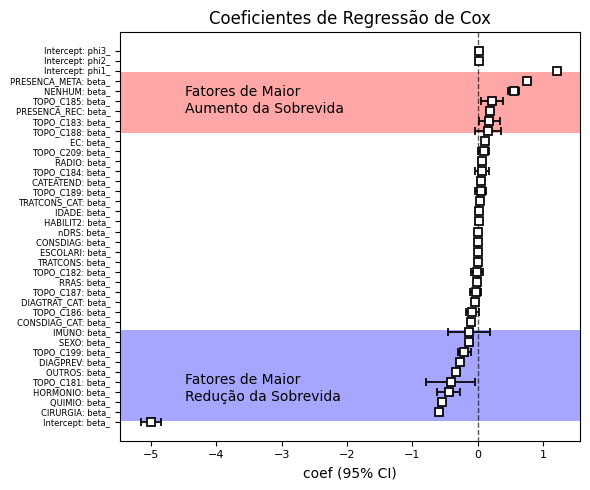

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1,1,figsize=(6, 5))
cph.plot()
plt.yticks(fontsize=6)
plt.xticks(fontsize=8)
plt.title('Coeficientes de Regressão de Cox')

ax = plt.gca()

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Calculate the x-coordinates for the shading
x_coords_red = [xlim[1] - i for i in range(4,11)]
x_coords_blue = [xlim[0] + i for i in range(2,10)]

y_coords_red = [ylim[1] - i for i in range(4,11)]
y_coords_blue = [ylim[0] + i for i in range(2,10)]

# Rectangle(xy, width, height, **kwargs)
#
#                +------------------+
#                |                  |
#              height               |
#                |                  |
#               (xy)---- width -----+
#
rect_blue = patches.Rectangle((xlim[0], y_coords_blue[0]), xlim[1] - xlim[0], y_coords_blue[-1] - ylim[0], linewidth=0, facecolor='blue', alpha=0.35)
rect_red  = patches.Rectangle((xlim[0], y_coords_red[0]), xlim[1] - xlim[0], y_coords_red[-1] - y_coords_red[0], linewidth=0, facecolor='red', alpha=0.35)

ax.text(xlim[0]+1,y_coords_blue[2],'Fatores de Maior\nRedução da Sobrevida') # ,weight='bold')
ax.text(xlim[0]+1,y_coords_red[4],'Fatores de Maior\nAumento da Sobrevida') # ,weight='bold')

ax.add_patch(rect_red)
ax.add_patch(rect_blue)

plt.tight_layout()
plt.show()

## Exclusão dos preditores de coeficientes não significativos

In [18]:
 cph.summary[ cph.summary.loc[:, 'p'] > 0.05 ]['p'].reset_index()

,param,covariate,p
0,beta_,ESCOLARI,0.891268
1,beta_,IMUNO,0.415567
2,beta_,HABILIT2,0.109132
3,beta_,TOPO_C182,0.862591
4,beta_,TOPO_C184,0.232525
5,beta_,TOPO_C186,0.112636
6,beta_,TOPO_C187,0.501903
7,beta_,TOPO_C188,0.126498
8,beta_,TOPO_C189,0.309136


## Predição e Métricas do Melhor Modelo de Cox





In [19]:
%%time
cph = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)

preditores_alvo = list(set(df.columns) - set(['ESCOLARI','IMUNO','HABILIT2']) - set(preditores_3))

cph.fit(df[preditores_alvo], duration_col='time', event_col='event')
y_pred = cph.predict_expectation(df)

cph.print_summary()
print(f"C-index: {cph.score(df[preditores], scoring_method='concordance_index')}")

<lifelines.CoxPHFitter: fitted with 37499 total observations, 15421 right-censored observations>
             duration col = 'time'
                event col = 'event'
 number of baseline knots = 3
      baseline estimation = spline
   number of observations = 37499
number of events observed = 22078
           log-likelihood = -108510.45
         time fit was run = 2024-11-26 13:03:18 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param covariate                                                                                                      
beta_ HORMONIO      -0.44      0.64      0.09           -0.61           -0.27                0.54                0.76
      PRESENCA_META  0.76      2.14      0.02            0.71            0.81                2.04                2.24
      nDRS           0.00      1.00      0.00            0.00            0.01                1.00                1.01
      DIAGPREV      -0.27      0.76      0.02           -0.31           -0.24                0.74                0.79
      SEXO          -0.14      0.87      0.01           -0.17           -0.11                0.85                0.89
      TRATCONS      -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
      CATEATEND      0.05      1.05      0.00            0.04            0.05                1.05                1.05
      IDADE          0.02      1.02      0.00            0.02            0.02                1.02                1.02
      QUIMIO        -0.54      0.58      0.02           -0.58           -0.51                0.56                0.60
      CONSDIAG_CAT  -0.10      0.90      0.02           -0.14           -0.07                0.87                0.94
      CONSDIAG       0.00      1.00      0.00            0.00            0.00                1.00                1.00
      OUTROS        -0.32      0.73      0.03           -0.37           -0.26                0.69                0.77
      NENHUM         0.55      1.73      0.04            0.46            0.64                1.59                1.89
      EC             0.12      1.12      0.00            0.11            0.12                1.12                1.13
      CIRURGIA      -0.61      0.55      0.02           -0.64           -0.57                0.53                0.56
      RADIO          0.12      1.13      0.02            0.09            0.15                1.09                1.17
      TRATCONS_CAT   0.04      1.04      0.01            0.01            0.07                1.01                1.07
      DIAGTRAT_CAT  -0.04      0.96      0.01           -0.07           -0.02                0.93                0.98
      RRAS          -0.01      0.99      0.00           -0.02           -0.01                0.99                0.99
      PRESENCA_REC   0.19      1.21      0.02            0.15            0.22                1.16                1.25
      Intercept     -4.94      0.01      0.07           -5.07           -4.81                0.01                0.01
phi1_ Intercept      1.21      3.37      0.02            1.18            1.25                3.26                3.48
phi2_ Intercept      0.02      1.02      0.01            0.01            0.03                1.01                1.03
phi3_ Intercept      0.02      1.02      0.01            0.01            0.03                1.01                1.03

                     cmp to      z      p  -log2(p)
param covariate                                    
beta_ HORMONIO         0.00  -5.09 <0.005     21.39
      PRESENCA_META    0.00  32.73 <0.005    778.05
      nDRS             0.00   2.20   0.03      5.17
      DIAGPREV         0.00 -16.24 <0.005    194.66
      SEXO             0.00 -10.25 <0.005     79.55
      TRATCONS         0.00  -8.25 <0.005     52.51
      CATEATEND        0.00  24.33 <0.005    431.82
      IDADE            0.00  30.84 <0.005    691.51
      QUIMIO  

C-index: 0.751247299861403
CPU times: user 15.2 s, sys: 5.62 s, total: 20.8 s
Wall time: 16.1 s


In [20]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score

# Função para calcular as métricas de desempenho
def calcular_metricas(y_real, y_pred, modelo, X):

    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [21]:
calcular_metricas(df['time'], y_pred, cph, df[preditores_alvo])

{'MSE': 6364.742810530337,
 'RMSE': 79.77933824324653,
 'MAE': 62.563354633122266,
 'MAPE': 6.788736874478284}

## Discretizando os valores, 1, 3 e >5 anos

In [24]:
from sklearn.metrics import classification_report

def bin_meses(valores_in):
  valores = valores_in.copy()
  for i in range(len(valores)):
    if valores[i] <= 12:
      valores[i] = 1
    if valores[i] > 12 and valores[i] <= 60:
      valores[i] = 3
    if valores[i] > 60:
      valores[i] = 5
  return valores

print(classification_report(bin_meses(df['time'].values), bin_meses(y_pred.values)))

              precision    recall  f1-score   support

         1.0       0.82      0.18      0.30     10382
         3.0       0.47      0.29      0.36     16186
         5.0       0.40      0.92      0.55     10931

    accuracy                           0.44     37499
   macro avg       0.56      0.46      0.40     37499
weighted avg       0.55      0.44      0.40     37499



# Aprendizado de Máquina, RandomSurvivalForest

 RandomSurvivalForest como GradientBoostingSurvivalAnalysis e KNeighborsSurvival apresentam resultados muito próximos.

## Treinamento do Modelo

In [25]:
%%time
rsf = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=42)

X = df.drop(columns=['event','time'])
y = np.array(list(zip(df['event'], df['time'])), dtype=[('event', bool), ('time', float)])

rsf.fit(X,y)
print(f'C-Index {rsf.score(X,y)}')

C-Index 0.7789650273178799
CPU times: user 9min 44s, sys: 1min 19s, total: 11min 4s
Wall time: 6min 40s


In [26]:
%%time
surv_rsf = rsf.predict_survival_function(X, return_array=True)
surv_rsf_mean = surv_rsf.mean(axis=0)

CPU times: user 1min 13s, sys: 41 s, total: 1min 54s
Wall time: 1min 7s


## Curva de Sobrevivência

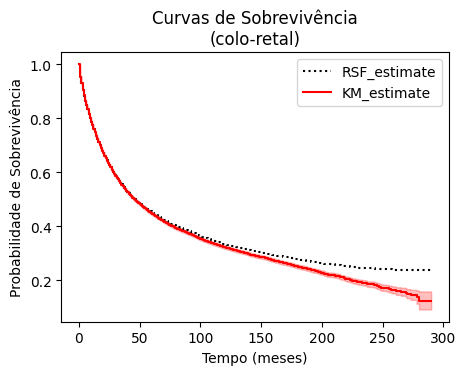

In [34]:
fig, ax = plt.subplots(1,1,figsize=(5, 3.5))

ax.step(rsf.unique_times_, surv_rsf_mean, where='post', label='RSF_estimate',color='k',linestyle=':')

# Curva de sobrevivência de Kaplan-Meier
kmf.plot_survival_function(ax=ax,color='r')

ax.set_title('Curvas de Sobrevivência\n(colo-retal)')
ax.set_xlabel('Tempo (meses)')
ax.set_ylabel('Probabilidade de Sobrevivência')

plt.legend()

plt.show()

## Importância das Features

In [ ]:
%%time
%%script echo skipping

from sklearn.inspection import permutation_importance
result_rsf = permutation_importance(rsf, X, y, n_repeats=5, random_state=42)



In [ ]:
%%script echo skipping
result_rsf_df = pd.DataFrame({k: result_rsf[k]for k in ("importances_mean", "importances_std")},
             index=feat_cols).sort_values(by="importances_mean", ascending=False)

plt.figure(figsize=(7,4))
plt.barh(result_rsf_df.index, result_rsf_df['importances_mean'], xerr=result_df['importances_std'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance with Standard Deviation')
plt.show()

## Predição do Tempo de Sobrevida

Não há um função direta no `surv` para cálculo direto do tempo de vida. O valor pode ser obtido integrando a curva de sobrevivência estimada.

In [35]:
def expected_survival_time(survival_func, time_points):
    # Discretizando a integral
    expected_time = 0
    for i in range(len(time_points) - 1):
        dt = time_points[i+1] - time_points[i]
        # valor médio da função de sobrevivência entre os pontos
        avg_survival = (survival_func[i] + survival_func[i+1]) / 2
        expected_time += avg_survival * dt
    return expected_time

In [36]:
%%time
surv = rsf.predict_survival_function(X, return_array=True)

# Limite de tempo
limite_tempo = df['time'].max()
units = surv.shape[1]

# Tempo ao longo do qual você deseja calcular a expectativa de vida
time_points = np.linspace(0, limite_tempo, num=units)

# Cálculo do tempo de sobrevivência esperado para o primeiro indivíduo
expected_time = expected_survival_time(surv[0], time_points)
print(f"O tempo de sobrevivência estimado: {expected_time:.2f}")

O tempo de sobrevivência estimado: 84.74
CPU times: user 1min 12s, sys: 40.9 s, total: 1min 53s
Wall time: 1min 21s


In [37]:
y_pred = []
for i in range(surv.shape[0]):
  expected_time = expected_survival_time(surv[i], time_points)
  y_pred.append(expected_time)



## Discretizando os valores, 1, 3 e >5 anos

In [39]:
print(classification_report(bin_meses(df['time'].values), bin_meses(y_pred)))

              precision    recall  f1-score   support

         1.0       0.95      0.11      0.20     10382
         3.0       0.46      0.27      0.34     16186
         5.0       0.39      0.95      0.55     10931

    accuracy                           0.43     37499
   macro avg       0.60      0.45      0.37     37499
weighted avg       0.58      0.43      0.37     37499



In [41]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(bin_meses(df['time'].values), bin_meses(y_pred), average='macro')
print(f"F1-score (macro): {f1}")

acc = accuracy_score(bin_meses(df['time'].values), bin_meses(y_pred))
print(f"accuracy score: {acc}")

F1-score (macro): 0.36723337064772404
accuracy score: 0.4271580575482013


# Aprendizado de Máquina, RandomForestRegressor

 Os modelos de sobrevivência, em geral previlegiam o C-index pois priorizam classificar e ordenar as previsões com relação ao risco. Modelos de regressores podem fornecer melhores previsões em termos absolutos, MSE ou RMSE, embora com um C-index baixo.

 A indicação de dos censurados, entretanto, não pode ser um preditor do modelo e uma alternativa é buscar o encode dessa informação em conjunto com a variável alvo (o tempo de vida). Aqui adota-se o seguinte esquema de encode da variável alvo:

 $$y= \begin{cases}
 -\lambda y,  \space   \space  \space   \text{if } \text{event }\\
 y, \space  \space  \space  \space  \space  \space  \space  \space  \space \text{if } \text{not event (censored)}
  \end{cases}$$



## Escolha do $\lambda$ para o encode

In [49]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, accuracy_score

X = df.drop(columns=['event', 'time'])

Lambda_metrics = {}

for Lambda in np.arange(-2, -0.5, 0.25):

  y_real_ml = df['time'] * df['event'].replace({0: 1, 1: Lambda})
  X_train, X_test, y_train, y_test = train_test_split(X, y_real_ml, stratify=df['event'], test_size=0.2, random_state=42)

  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  f1 = f1_score(bin_meses(y_test.values), bin_meses(y_pred), average='macro')
  acc = accuracy_score(bin_meses(y_test.values), bin_meses(y_pred))

  Lambda_metrics[Lambda] = {'mse': mse, 'f1': f1, 'acc': acc}
  print(Lambda_metrics[Lambda])


{'mse': 8585.451876809393, 'f1': 0.4609391386510069, 'acc': 0.6332}
{'mse': 7345.474692358509, 'f1': 0.4711129840566011, 'acc': 0.6316}
{'mse': 6217.0552502941, 'f1': 0.4765914918493334, 'acc': 0.6230666666666667}
{'mse': 5267.797422196769, 'f1': 0.48408587125993763, 'acc': 0.6122666666666666}
{'mse': 4398.566168652459, 'f1': 0.4905843578476356, 'acc': 0.6006666666666667}
{'mse': 3653.422030116898, 'f1': 0.48965011011078946, 'acc': 0.5830666666666666}
CPU times: user 2min 55s, sys: 247 ms, total: 2min 55s
Wall time: 3min 2s


In [50]:
pd.DataFrame(Lambda_metrics).T

,mse,f1,acc
-2.00,8585.451877,0.460939,0.633200
-1.75,7345.474692,0.471113,0.631600
-1.50,6217.055250,0.476591,0.623067
-1.25,5267.797422,0.484086,0.612267
-1.00,4398.566169,0.490584,0.600667
-0.75,3653.422030,0.489650,0.583067


In [52]:
min_mse_lambda = min(Lambda_metrics, key=lambda k: Lambda_metrics[k]['mse'])

print(f"The Lambda value with the minimum MSE is: {min_mse_lambda}")
print(f"The corresponding metrics are: {Lambda_metrics[min_mse_lambda]}")

The Lambda value with the minimum MSE is: -0.75
The corresponding metrics are: {'mse': 3653.422030116898, 'f1': 0.48965011011078946, 'acc': 0.5830666666666666}


## Melhor Modelo

In [54]:
X = df.drop(columns=['event', 'time'])

Lambda_metrics = {}

Lambda -0.75

y_real_ml = df['time'] * df['event'].replace({0: 1, 1: Lambda})
X_train, X_test, y_train, y_test = train_test_split(X, y_real_ml, stratify=df['event'], test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
f1 = f1_score(bin_meses(y_test.values), bin_meses(y_pred), average='macro')
acc = accuracy_score(bin_meses(y_test.values), bin_meses(y_pred))

Lambda_metrics[Lambda] = {'mse': mse, 'f1': f1, 'acc': acc}
print(Lambda_metrics[Lambda])

{'mse': 3653.422030116898, 'f1': 0.48965011011078946, 'acc': 0.5830666666666666}


## Discretizando os valores, 1, 3 e >5 anos

In [55]:
print(classification_report(bin_meses(y_test.values), bin_meses(y_pred)))

              precision    recall  f1-score   support

         1.0       0.83      0.67      0.75      4737
         3.0       0.27      0.63      0.38      1261
         5.0       0.51      0.26      0.34      1502

    accuracy                           0.58      7500
   macro avg       0.54      0.52      0.49      7500
weighted avg       0.68      0.58      0.60      7500



In [56]:
def c_index(y_true, y_pred):
    n = len(y_true)
    c_index_value = 0
    for i in range(n):
        for j in range(i + 1, n):
            if y_true[i] != y_true[j]:
                if (y_pred[i] > y_pred[j] and y_true[i] > y_true[j]) or \
                   (y_pred[i] < y_pred[j] and y_true[i] < y_true[j]):
                    c_index_value += 1
                elif y_pred[i] == y_pred[j]:
                    c_index_value += 0.5
    return c_index_value / (n * (n - 1) / 2)

# Calculate C-index
c_index_result = c_index(bin_meses(y_test.values), bin_meses(y_pred))
print(f"C-index (by definition): {c_index_result}")

C-index (by definition): 0.38117222740809886


In [57]:
y_test = np.array(list(zip(df.loc[X_test.index]['event'], df.loc[X_test.index]['time'])), dtype=[('event', bool), ('time', float)])
c_index = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]

print(f"C-index: {c_index}")

C-index: 0.3386374869225539


# Conclusão

O modelo de regressão de Cox e os modelos de aprendizado de máquina para sobrevivência têm o mesmo princípio e priorizam a determinação do risco. Tendo o mesmo princípio chegam a resultados bastante próximos na predição de valores dos tempos de sobrevivência, com $\approx 0.44$ de acuracidade para determinação de valores nas classes de $<1$ ano, entre $3-5$ anos e $>5$ anos. Já um modelo aprendizado de máquina para regressão (um modelo ensemble, `RandomForestRegressor`), tendo como princípio a minimização do erro, apresentou resultados melhores de predição com $\approx 0.58$ de acuracidade para as mesmas classes de tempo de vida.

Esse é um resultado preliminar e estudos mais detalhados no futuro devem envolver principalmente, avaliar outras técnicas de *encode* dos eventos à variável alvo, algo que parece promissor. Outros tipos de câncer e técnicas aumento de dados para equilibrar os caso de evento e  censurados, também devem ser avaliados.